<font size=6>**Deep Learning - Workshop: Diffusion Models**</font>


<font size=4>IMPORTANT: Don't forget to activate GPU!</font>

# POV: You need to model a distribution!

Let's suppose we are given some [unknown] **empirical distribution**, and we need to generate **mock data**.

<div>
   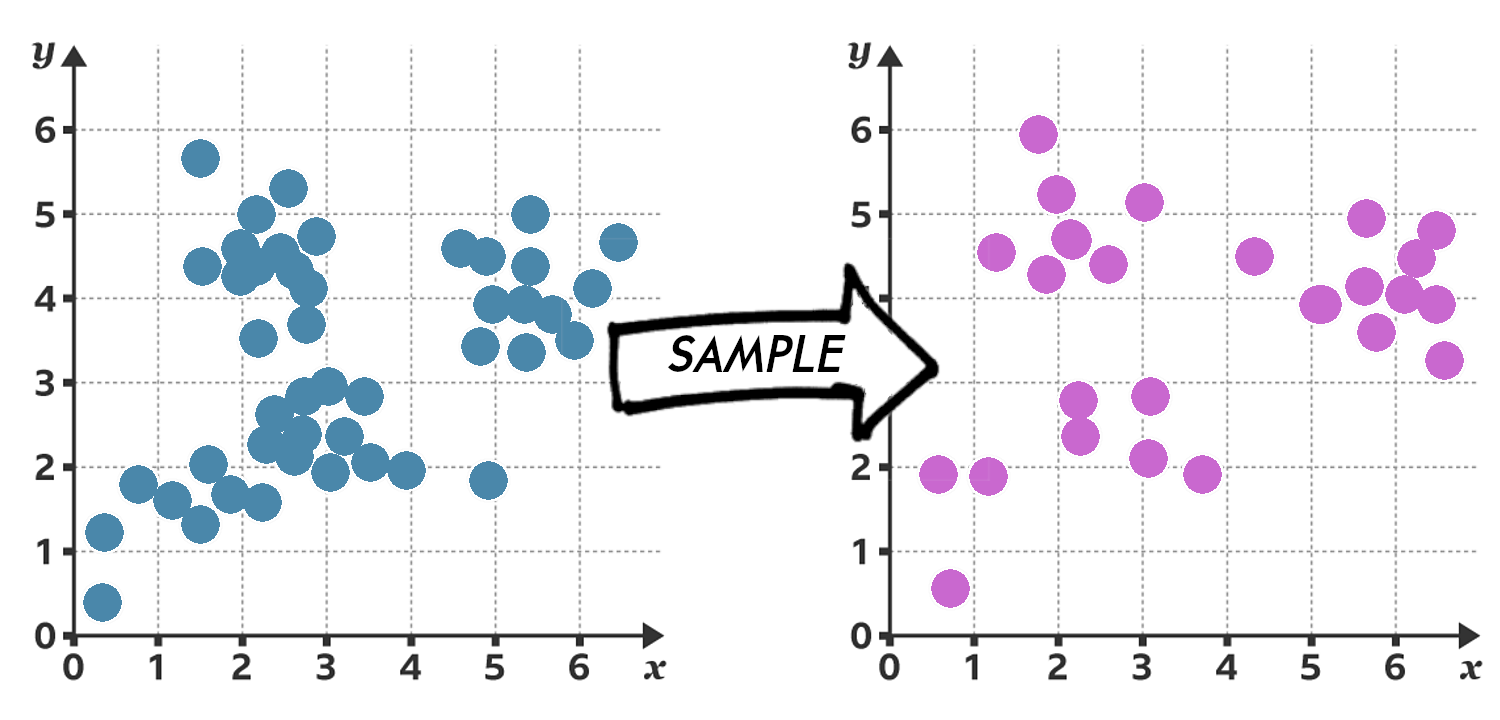
</div>

<table><tr>
    <td width=700>
        <center>
            <br>
            Figure 1.1. The sampling problem.  We need to sample some data (<i>right</i>) based on some empirical distribution (<i>left</i>).<br>
        </center>
    </td>
</tr></table>

<font size=3><u>**Example cases**</u><font>

E.g., you are:

- Running an **expensive simulation** $\rightarrow$ cannot generate _all_ the data analytically

- Dealing with **imbalanced data** $\rightarrow$ need more examples of the minority class

- Assessing **some statistics** $S$ $\rightarrow$ would like to "bootstrap" to obtain a distribution for $S$

<font size=3><u>**In-class discussion**</u><font>

What would you do, if you had to sample _pseudo_-real data given a dataset?
    
_Discuss a few mins with your teammate, then report.  This of possible pros and cons of your method._

<details>
<summary><b>[Spoiler]</b></summary>
<br>
E.g. <b>KDE</b> (<b>Kernel Density Estimation</b>)
<br>
<code>sklearn.neighbors.KernelDensity</code>

We can think of KDE as a **smoothed distribution** (e.g. via Gaussians) of the data.    

<div>
   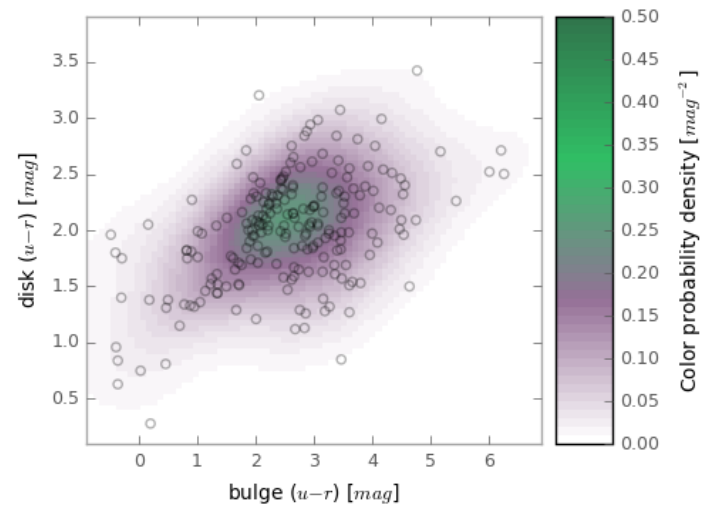
</div>

<table><tr>
    <td width=700>
        <center>
            <br>
            Figure 1b. An example of Kernel Density Estimation applied to a 2D color-color distribution.<br>
            (From <a herf="https://ui.adsabs.harvard.edu/abs/2021MNRAS.504.3831B/abstract">Bonfini et al. (2021)</a>)
        </center>
    </td>
</tr></table>

$\rightarrow$ From this **continuous** distribution we can now sample new datasets.
    
<b>PROS</b>:<br>
- Intuitive<br>
- Computationally quick
    
<b>CONS:</b><br>
- Needs parameter tuning (_kernel width_)
- Same global smoothing all over the feature ranges
</details>

- - -
    
In general, a powerful, generalizable model would:
    
- not have **parameters defined ad-hoc** (_parametric models are difficult to define for complex distributions_)
- accounting implicitly for **correlations between features**  
- **adaptable** to the local sub-distribution densities
- **unsupervised**

$\rightarrow$ e.g., **Generative Models**    

## Generative Models $vs$ Discriminative Models

What are **Generative Models**? $\rightarrow$ Best understood when defined in contrast to **Discriminative Models**.

<div>
   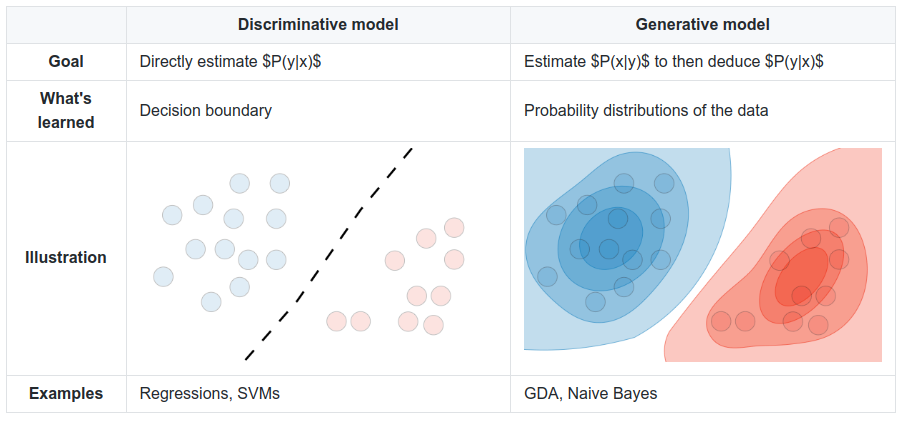
</div>

<table><tr>
    <td width=800>
        <center>
            <br>
            Figure 1.2. Summary comparison of Discriminative (<i>left</i>) $vs$ Generative (<i>right</i>) Models.<br>
            (From <a href=https://stanford.edu/~shervine/teaching/cs-229/cheatsheet-supervised-learning>here</a>)
        </center>
    </td>
</tr></table>

A new paradigm to catalog ML models $\rightarrow$ they can be distinguished based on <u>which probability distribution they target</u>.
 
**Discriminative Models**
- **Objective** $\rightarrow$ Differenciate between sample labels
- **Method** $\rightarrow$ Learn the conditional probability $P(y | X)$

        "How likely is this label?"

**Generative Models**
- **Objective** $\rightarrow$ Create new samples
- **Method** $\rightarrow$ Learn the joint probability $P(X, y)$ $-$ or just $P(X)$ if unsupervised
    
        "How likely is this sample, or this <sample, label> pair?"

See this [Google Developers post](https://developers.google.com/machine-learning/gan/generative) for a smooth intro.

# Diffusion models

- Fancy image generator

- astro: https://github.com/smith42/astroddpm

- Theory from 2D example

# Building a diffusion model

This example has been coded based on [this work](https://medium.com/mlearning-ai/a-toy-diffusion-model-you-can-run-on-your-laptop-20e9e5a83462) by Thiago Lira. 

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device in use [cpu/cuda]:', device)

Device in use [cpu/cuda]: cuda


## Importing Data


In [3]:
import os
import wget
import pandas as pd

path_data = './data'
# path of data folder

path_to_data = path_data+"/BPT_emlines.csv"
# path/to/file to be created

# > BPT_emlines.csv
link_data = "https://drive.google.com/uc?id=1wKRU9OKhUcB4Pr3nDYNcNtS2tJpeldek"
#
# Original link: https://drive.google.com/file/d/1wKRU9OKhUcB4Pr3nDYNcNtS2tJpeldek/view?usp=share_link
# - replace: "file/d/" with "uc?id="
# - remove: "/view?usp=share_link"

if not os.path.exists(path_data):
    os.makedirs(path_data)

if not os.path.exists(path_to_data):
    response = wget.download(link_data, path_to_data)

df_data = pd.read_csv(path_to_data)

# Limiting data:
#n_samples = 10000
#df_data = df_data.sample(n=n_samples, random_state=42)
frac_sampling = 0.02
df_data = df_data.groupby('Target_class', group_keys=False).apply(lambda x: x.sample(frac=frac_sampling))
# stratified sampling

display(df_data.head(5))
print(df_data.shape)

,log_sqred_OIII_5007_EQW,D4000_N,log(OIII_5007/H_BETA),log(NII_6584/H_ALPHA),Target_class
28350,1.759275,1.548203,0.757181,-0.017492,AGN
8180,2.356018,1.302929,0.336873,-0.232958,AGN
2411,2.483429,1.492585,0.589187,-0.145112,AGN
15946,3.036162,1.301555,0.507177,-0.199395,AGN
19408,2.891013,1.342081,0.614205,-0.077494,AGN


(906, 5)


## Visualizing data

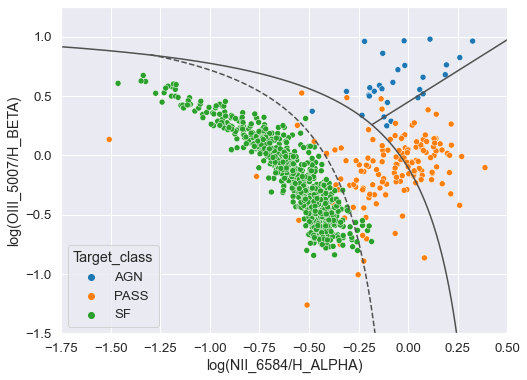

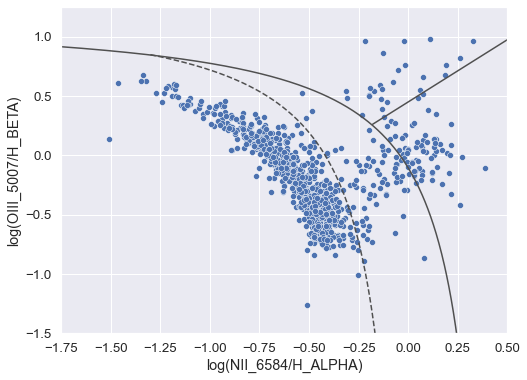

In [4]:
import seaborn as sns
from matplotlib import pyplot as plt

# Global Seaborn setup for the reminder of the notebook:
sns.set(font_scale=1.2)

def plot_data(df_data, colored=True, display=True):
    
    if display:
        plt.figure(figsize=(8, 6))

    if colored:
        ax = sns.scatterplot(data=df_data, x='log(NII_6584/H_ALPHA)', y='log(OIII_5007/H_BETA)',
                    hue='Target_class', palette='tab10')
    else:
        ax = sns.scatterplot(data=df_data, x='log(NII_6584/H_ALPHA)', y='log(OIII_5007/H_BETA)')
            
    # Kewley+01:
    xx_Ke = np.linspace(-2.5, 0.3, 1000)
    yy_Ke = (0.61/( xx_Ke  - 0.47  )) + 1.19

    # Schawinski+07:
    xx_Sc = np.linspace(-0.180, 1.5, 1000)
    yy_Sc = 1.05*xx_Sc + 0.45

    # Kauffmann+03:
    xx_Ka = np.linspace(-1.3, 0., 1000)
    yy_Ka = 0.61/(xx_Ka -0.05) + 1.3

    plt.plot(xx_Ke, yy_Ke, '-' , color='#505050') # Kewley+01
    plt.plot(xx_Sc, yy_Sc, '-',  color='#505050') # Schawinski+07
    plt.plot(xx_Ka, yy_Ka, '--', color='#505050') # Kauffmann+03     
        
    plt.ylim(-1.5,1.25)
    plt.xlim(-1.75,0.5)
    
    if display:
        plt.show()
    
plot_data(df_data, colored=True)
plot_data(df_data, colored=False)

## Splitting

_You know the drill ..._

In [5]:
from sklearn.model_selection import train_test_split
from prettytable import PrettyTable

df_X_train, df_X_valid, df_y_train, df_y_valid = \
    train_test_split(df_data[['log(NII_6584/H_ALPHA)', 'log(OIII_5007/H_BETA)']],
                     df_data['Target_class'], test_size=0.5, random_state=42)

table = PrettyTable()
table.title = str('Data shape')
table.field_names = ['set', 'X', 'y']
table.add_row(['train',   np.shape(df_X_train), np.shape(df_y_train)])
table.add_row(['valid', np.shape(df_X_valid), np.shape(df_y_valid)])
print(table)

+---------------------------+
|         Data shape        |
+-------+----------+--------+
|  set  |    X     |   y    |
+-------+----------+--------+
| train | (453, 2) | (453,) |
| valid | (453, 2) | (453,) |
+-------+----------+--------+


## Scaling

In [6]:
# Scaling:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_X_train_n = df_X_train.copy()
df_X_valid_n = df_X_valid.copy()

df_X_train_n[['log(NII_6584/H_ALPHA)', 'log(OIII_5007/H_BETA)']] =\
    scaler.fit_transform(df_X_train_n[['log(NII_6584/H_ALPHA)', 'log(OIII_5007/H_BETA)']])

df_X_valid_n[['log(NII_6584/H_ALPHA)', 'log(OIII_5007/H_BETA)']] =\
    scaler.transform(df_X_valid_n[['log(NII_6584/H_ALPHA)', 'log(OIII_5007/H_BETA)']])

display(df_X_train.head(3))
display(df_X_train_n.head(3))

,log(NII_6584/H_ALPHA),log(OIII_5007/H_BETA)
45039,-0.411171,0.006146
4706,-0.786187,0.191154
6591,-0.891736,0.047601


,log(NII_6584/H_ALPHA),log(OIII_5007/H_BETA)
45039,0.318853,0.491210
4706,-1.013654,1.036232
6591,-1.388691,0.613332


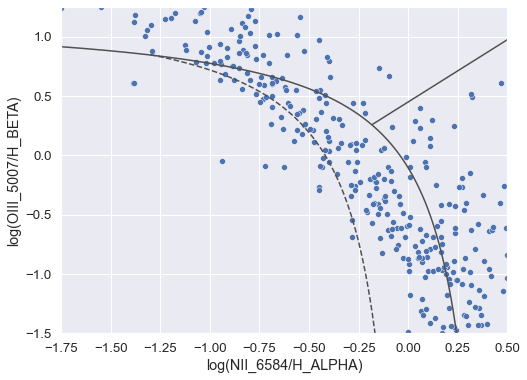

In [7]:
plot_data(df_X_train_n, colored=False)

In [8]:
# Sending data to device:
X_train = torch.tensor(df_X_train_n[['log(NII_6584/H_ALPHA)', 'log(OIII_5007/H_BETA)']].values)\
            .to(torch.float32).to(device)
X_valid = torch.tensor(df_X_valid_n[['log(NII_6584/H_ALPHA)', 'log(OIII_5007/H_BETA)']].values)\
            .to(torch.float32).to(device)

n_features = np.shape(X_train)[1]
print('Number of features:', n_features)

Number of features: 2


### Measure K-L

sklearn.metrics.mutual_info_score([0,1],[1,0])

In [ ]:
###EOF

In [ ]:
###EOF